<a href="https://colab.research.google.com/github/hyeonisism/ml/blob/main/kant_diamond_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
pip install numpy pandas torch matplotlib scikit-learn seaborn

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, DataLoader

In [50]:
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/diamonds.csv"
data = pd.read_csv(url)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [51]:
data.shape

(53940, 10)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [53]:
data = data[(data[['x','y','z']] != 0).all(axis=1)].reset_index(drop=True)

In [54]:
categorical_cols = ['cut', 'color', 'clarity']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [55]:
print(data.isnull().sum())

carat            0
depth            0
table            0
price            0
x                0
y                0
z                0
cut_Good         0
cut_Ideal        0
cut_Premium      0
cut_Very Good    0
color_E          0
color_F          0
color_G          0
color_H          0
color_I          0
color_J          0
clarity_IF       0
clarity_SI1      0
clarity_SI2      0
clarity_VS1      0
clarity_VS2      0
clarity_VVS1     0
clarity_VVS2     0
dtype: int64


In [56]:
data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False


In [57]:
data = data.apply(pd.to_numeric, errors='coerce')

In [58]:
data = data.dropna()

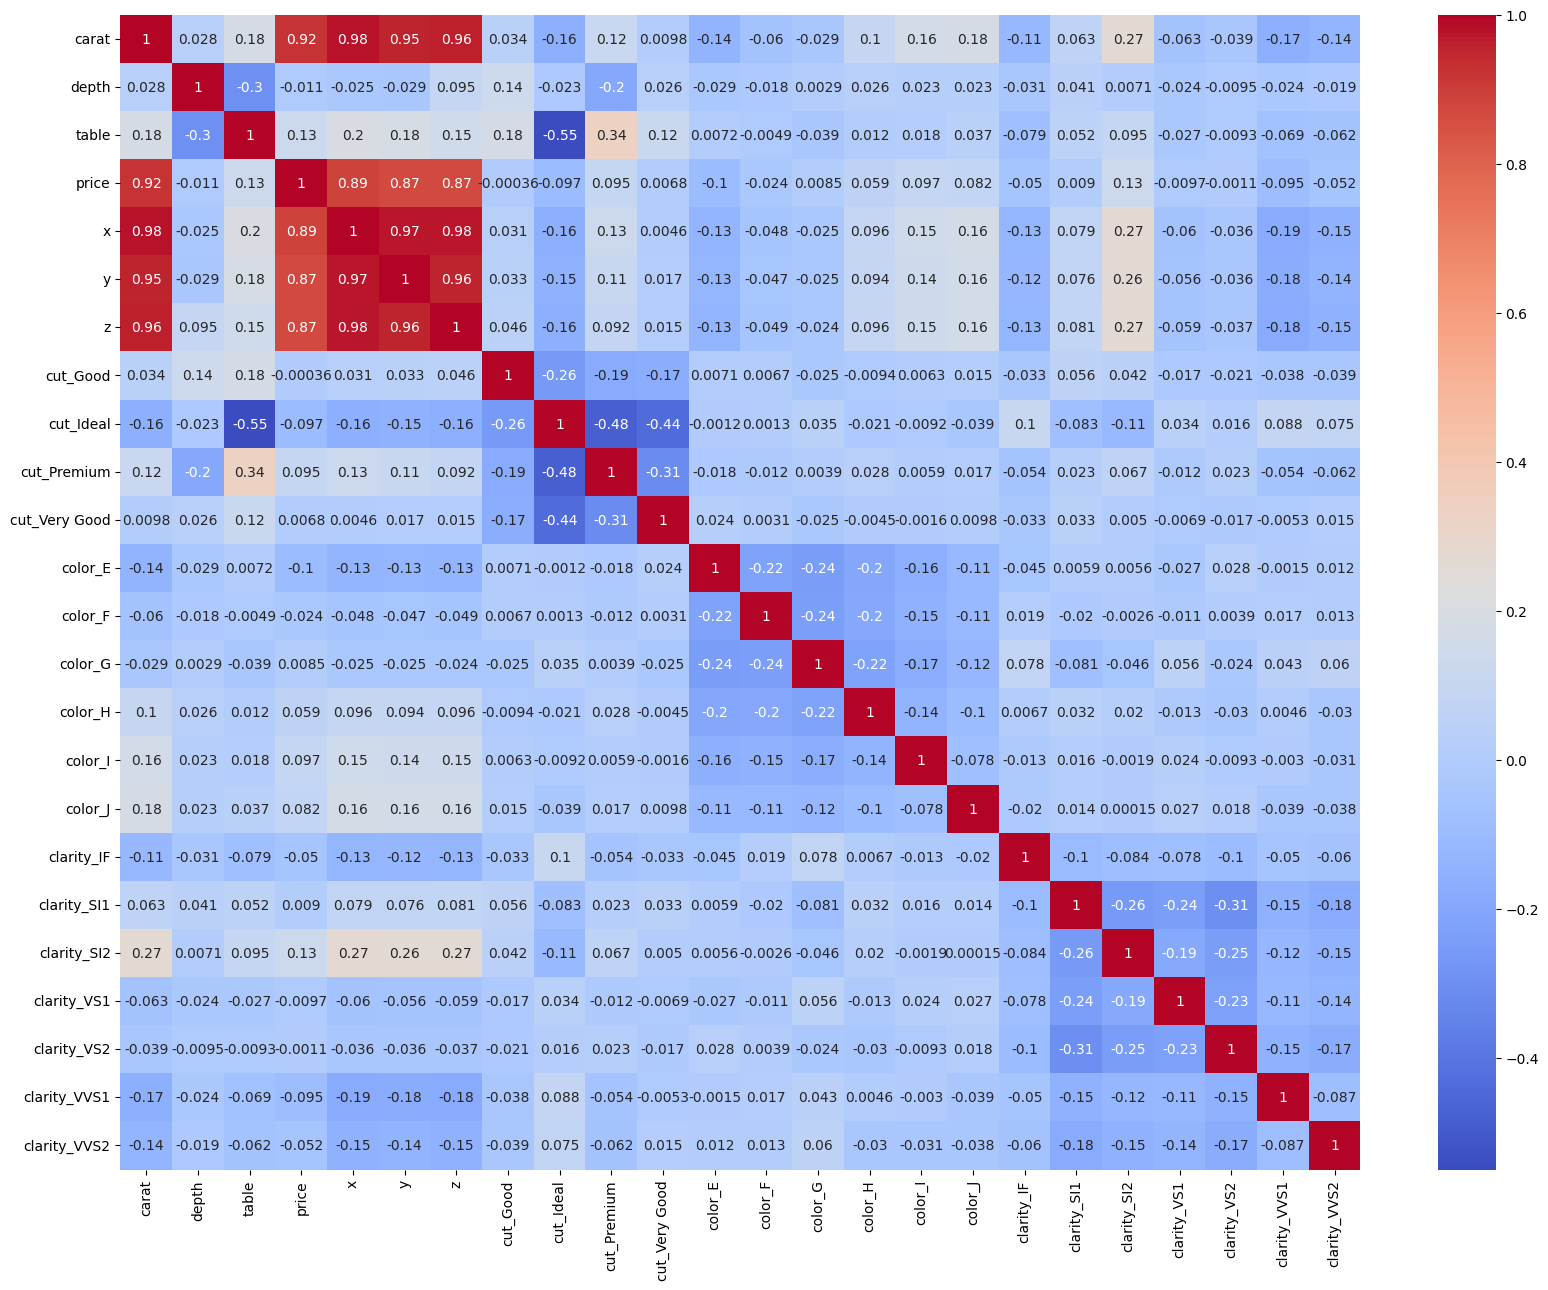

In [59]:
plt.figure(figsize = (20,15))
sns.heatmap(data.corr(),annot = True , cmap = 'coolwarm' );

In [60]:
X = data.drop('price', axis=1)
Y = data['price']

X_array = X.values.astype(np.float32)
Y_array = Y.values.reshape(-1, 1).astype(np.float32)

X_tensor = torch.tensor(X_array)
Y_tensor = torch.tensor(Y_array)

In [61]:
dataset = TensorDataset(X_tensor, Y_tensor)

torch.manual_seed(42)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [62]:
class DiamonPriceModel(nn.Module):
  def __init__(self, input_dim):
    super(DiamonPriceModel, self).__init__()
    self.linear = nn.Linear(input_dim, 1)

  def forward(self, x):
    return self.linear(x)

  def training_step(self, batch):
      inputs, targets = batch
      outputs = self(inputs)
      loss = F.mse_loss(outputs, targets)
      return loss

  def validation_step(self, batch):
      inputs, targets = batch # targets를 device로 이동
      outputs = self(inputs)
      loss = F.mse_loss(outputs, targets)
      return {'val_loss': loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    return {'val_loss': epoch_loss.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


In [63]:
input_dim = X_tensor.shape[1]
model = DiamonPriceModel(input_dim)

In [64]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [65]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, optimizer):
  history = []
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history


history = fit(50, model, train_loader, test_loader, optimizer)


Epoch [0], val_loss: 8937799.0000
Epoch [1], val_loss: 6315266.0000
Epoch [2], val_loss: 4574937.5000
Epoch [3], val_loss: 4011560.2500
Epoch [4], val_loss: 4005485.0000
Epoch [5], val_loss: 3657107.7500
Epoch [6], val_loss: 3738831.5000
Epoch [7], val_loss: 3660100.2500
Epoch [8], val_loss: 3562069.2500
Epoch [9], val_loss: 3816567.2500
Epoch [10], val_loss: 3532639.5000
Epoch [11], val_loss: 3523191.0000
Epoch [12], val_loss: 3465972.2500
Epoch [13], val_loss: 3435527.2500
Epoch [14], val_loss: 3443197.7500
Epoch [15], val_loss: 3519145.0000
Epoch [16], val_loss: 3408826.0000
Epoch [17], val_loss: 3736316.2500
Epoch [18], val_loss: 3520587.2500
Epoch [19], val_loss: 3365013.5000
Epoch [20], val_loss: 3338601.7500
Epoch [21], val_loss: 3348865.5000
Epoch [22], val_loss: 3333528.2500
Epoch [23], val_loss: 3310404.2500
Epoch [24], val_loss: 3340403.5000
Epoch [25], val_loss: 3268605.2500
Epoch [26], val_loss: 3255598.2500
Epoch [27], val_loss: 3414044.7500
Epoch [28], val_loss: 3268691.

In [66]:
model.eval()
with torch.no_grad():
    val_predictions = []
    val_targets = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        val_predictions.extend(outputs.squeeze(1).numpy())
        val_targets.extend(targets.squeeze(1).numpy())

In [67]:
r2 = r2_score(val_targets, val_predictions)
print(f'검증 데이터 R^2 스코어: {r2:.4f}')

검증 데이터 R^2 스코어: 0.8015


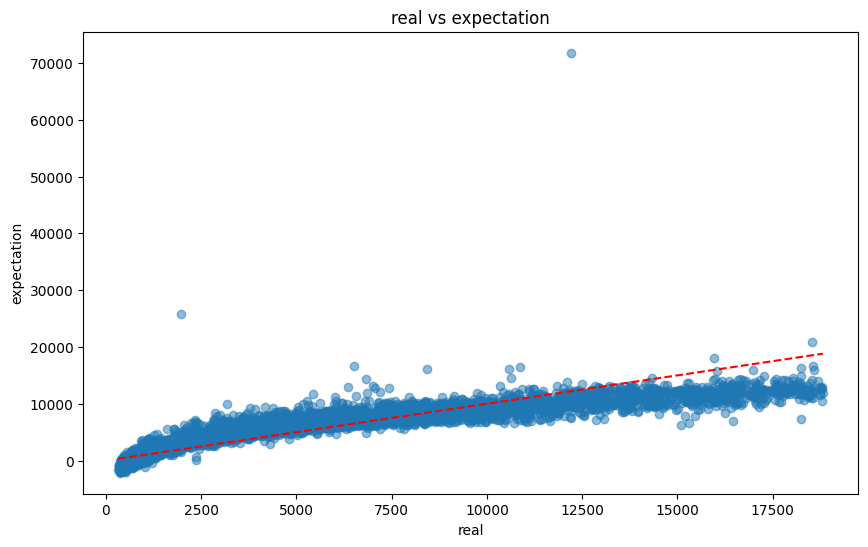

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(val_targets, val_predictions, alpha=0.5)
plt.title('real vs expectation')
plt.xlabel('real')
plt.ylabel('expectation')
plt.plot([min(val_targets), max(val_targets)], [min(val_targets), max(val_targets)], 'r--')
plt.show()